<a href="https://colab.research.google.com/github/praveenpiisc/cp250/blob/main/1_Snakemake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

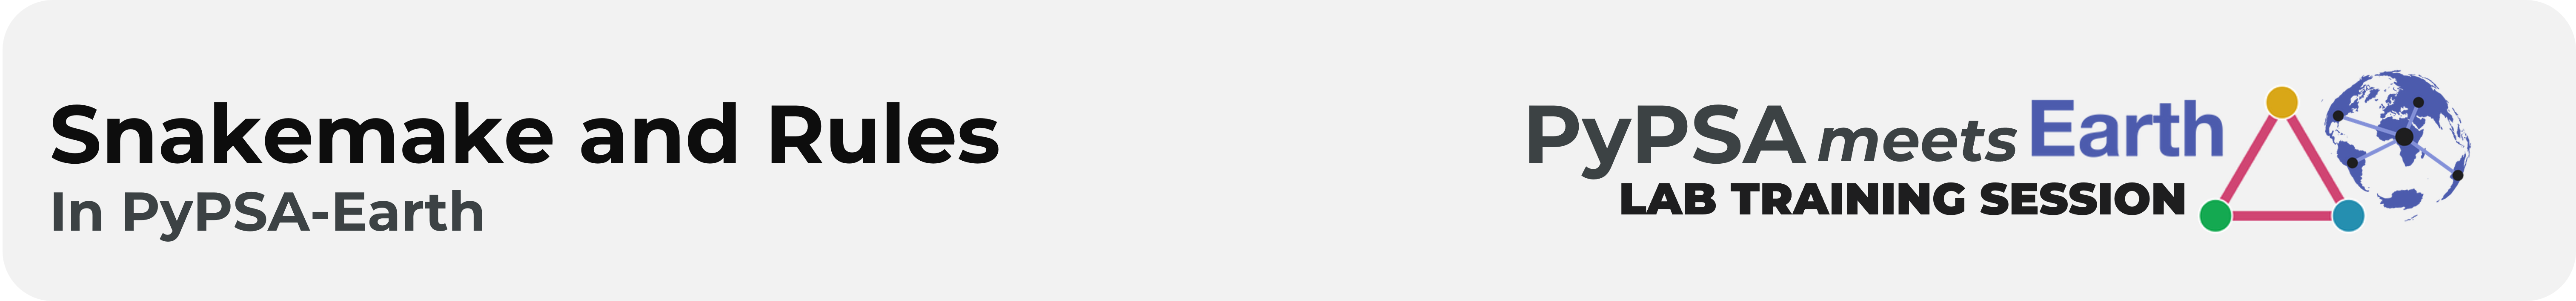

<div style="display: flex; align-items: center; justify-content: space-between; gap: 20px; flex-wrap: wrap;">

  <div style="flex: 1; min-width: 250px;">
    <p><strong>Authors:</strong><br>
    Eddy Jalbout – PhD Candidate, Fraunhofer IEG</p>
  </div>

  <div style="flex: 0 0 auto;">
    <a href="https://www.ieg.fraunhofer.de/en.html" target="_blank">
      <img src="https://www.ieg.fraunhofer.de/content/dam/ieg/ieg.svg" height="60" alt="Fraunhofer IEG logo">
    </a>
  </div>

</div>



**Aim:**

This notebook provides an on-hands overview of the snakemake rules of the sector-coupled energy system modelling framework [PyPSA-Earth](https://github.com/pypsa-meets-earth/pypsa-earth).

The scope of this exercise is to explore snakemake orchestration of the workflow, as well as, some critical rules or scripts within the PyPSA-Earth model.

:::{note} This documents builds upon the work done by:

Iegor Riepin – Postdoctoral researcher at the Energy Systems group at TU

# 🐍 Introduction to Snakemake and Critical Rules within PyPSA-Earth:

## ⚙️ Setup Environment

#### ▪  Install the required packages

In [ ]:
# @markdown Run this cell to install the necessary Python packages for the project.

!pip install "pypsa>=0.25,<=0.30.3" atlite pandas geopandas xarray matplotlib hvplot geoviews plotly highspy holoviews folium mapclassify gdown snakemake country_converter py7zr fake_useragent

#### ▪  Import necessary packages

In [ ]:
# @markdown Here, the necessary Python packages for this exercise are loaded into the notebook.
# @markdown
# @markdown **Note:** If you encounter an error, go to Runtime->Restart session, you find this in the toolbar at the top of the website

import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches

import gdown
from urllib.request import urlretrieve
from IPython.display import Code, SVG, Image, IFrame, display
import importlib.util
import warnings
warnings.filterwarnings("ignore")

# Standard library
import os
import sys
import warnings
import yaml
from pathlib import Path
from datetime import datetime

# Scientific stack
import numpy as np
import pandas as pd
import xarray as xr

# PyPSA + related ecosystem
import pypsa
import atlite
import highspy  # HiGHS solver backend

# Geospatial & mapping
import geopandas as gpd
import folium
import mapclassify
import cartopy
from cartopy import crs as ccrs

# Plotting & visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import holoviews as hv
import hvplot.pandas      # activates .hvplot accessor
import geoviews as gv
import json

# PyPSA plotting helpers
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches

print('You are all set up - Let us go into it')

You are all set up - Let us go into it


## ◼ Snakemake

Download the needed data

In [ ]:
# @markdown Let's downmload the needed data for this notebook.

urls = {
    # "data/data_raw.csv": "https://storage.googleapis.com/open-tyndp-data-store/workshop-02/data_raw.csv",
    # "data/open-tyndp.zip": "https://storage.googleapis.com/open-tyndp-data-store/workshop-02/open-tyndp.zip",
    # "data/network_NT_presolve_highres_2030.nc": "https://storage.googleapis.com/open-tyndp-data-store/workshop-02/network_NT_presolve_highres_2030.nc",
    "minimal_example/Snakefile": "https://raw.githubusercontent.com/open-energy-transition/open-tyndp-workshops/refs/heads/main/open-tyndp-workshops/Snakefile",
    "minimal_example/scripts/build_data.py": "https://raw.githubusercontent.com/open-energy-transition/open-tyndp-workshops/refs/heads/main/open-tyndp-workshops/scripts/build_data.py",
    "minimal_example/scripts/prepare_network.py": "https://raw.githubusercontent.com/open-energy-transition/open-tyndp-workshops/refs/heads/main/open-tyndp-workshops/scripts/prepare_network.py",
    "minimal_example/scripts/filter_dag.py": "https://raw.githubusercontent.com/open-energy-transition/open-tyndp-workshops/refs/heads/main/open-tyndp-workshops/scripts/filter_dag.py",
    "minimal_example/logos/snakemake_logo.png":"https://drive.usercontent.google.com/download?id=1nsvACcHbJuHyqbAXmkwKah7pqC2nPZ6A&export=download",

}

os.makedirs("minimal_example/logos", exist_ok=True)
os.makedirs("minimal_example/data", exist_ok=True)
os.makedirs("minimal_example/scripts", exist_ok=True)
for name, url in urls.items():
    if os.path.exists(name):
        print(f"File {name} already exists. Skipping download.")
    else:
        print(f"Retrieving {name} from GCP storage.")
        urlretrieve(url, name)
        print(f"File available in {name}.")

print("Done")

File minimal_example/Snakefile already exists. Skipping download.
File minimal_example/scripts/build_data.py already exists. Skipping download.
File minimal_example/scripts/prepare_network.py already exists. Skipping download.
File minimal_example/scripts/filter_dag.py already exists. Skipping download.
File minimal_example/logos/snakemake_logo.png already exists. Skipping download.
Done


We now need to change our working directory to the minimal_example directory we just retrieved.

In [ ]:
os.chdir("minimal_example")

Let's check that we are indeed in the new directory now:

In [ ]:
os.getcwd()

'/content/minimal_example'

#### ▪ The `Snakemake` tool

<div style="text-align: center;">
  <img src="https://w7.pngwing.com/pngs/866/572/png-transparent-snakemake-dark-logo-tech-companies.png" width="400px" alt="Snakemake Logo">
</div>

The `Snakemake` workflow management system is a tool to create reproducible and scalable data analyses.
Workflows are described via a human readable, Python based language. They can be seamlessly scaled to server, cluster, grid, and cloud environments, without the need to modify the workflow definition.

Snakemake follows the [GNU Make](https://www.gnu.org/software/make) paradigm: workflows are defined in terms of so-called `rules` that specify how to create a set of output files from a set of input files. Dependencies between the rules are determined automatically, creating a DAG (directed acyclic graph) of jobs that can be automatically parallelized.

:::{note} Documentation for this package is available at https://snakemake.readthedocs.io/. You can also check out a slide deck Snakemake Tutorial by Johannes Köster (2024).

Mölder, F., Jablonski, K.P., Letcher, B., Hall, M.B., Tomkins-Tinch, C.H., Sochat, V., Forster, J., Lee, S., Twardziok, S.O., Kanitz, A., Wilm, A., Holtgrewe, M., Rahmann, S., Nahnsen, S., Köster, J., 2021. Sustainable data analysis with Snakemake. F1000Res 10, 33. :::

#### ▪ A minimal Snakemake example

To check out how this looks in practice, we've prepared a minimal Snakemake example workflow that processes some data. The minimal workflow consists of the following rules:
- `retrieve_data`
- `build_data`
- `prepare_network`
- `solve_network`
- `plot_benchmark`
- `all`

These rules are illustrative and mimic a workflow in PyPSA-Earth.

<center>

![](minimal_workflow.png)

</center>

We have already loaded the raw data file used in this minimal example into our working directory.

As you can see, the `plot_benchmark` rule will be called twice with two different filename extensions. For this, we are taking advantage of the concept of wildcards (`ext`). Snakemake will automatically resolve the wildcards using the dependency graph. In this case, the `all` rule takes as input both a `png` and a `pdf` figure which propagates back throughout the workflow.

##### ▪▪ The `Snakefile` and `rules`

The rules need to be defined in a so-called `Snakefile` that sits in your current working directory. For our minimal example the `Snakefile` looks like this:

In [ ]:
Code(filename="Snakefile", language="Python")

# SPDX-FileCopyrightText: Open Energy Transition gGmbH
#
# SPDX-License-Identifier: MIT

from pathlib import Path

rule all:
    input:
        "data/benchmark.png",
        "data/benchmark.pdf"

rule retrieve_data:
    output:
        "data/data_raw.csv"
    shell:
        "wget -O {output} https://storage.googleapis.com/open-tyndp-data-store/workshop-02/data_raw.csv"

rule build_data:
    input:
        "data/data_raw.csv"
    output:
        "data/data_filtered.csv"
    script:
        "scripts/build_data.py"

rule prepare_network:
    input:
        "data/data_filtered.csv"
    output:
        "data/base_2030.nc"
    script:
        "scripts/prepare_network.py"

rule solve_network:
    input:
        "data/base_2030.nc"
    output:
        "data/base_2030_solved.nc"
    shell:
        "cp {input} {output}"

rule plot_benchmark:
    input:
        "data/base_2030_solved.nc"
    output:
        "data/benchmark.{ext}"
    run:
        Path(output[0]).touch()

You can check out the scripts under `scripts`. You will see that they are simplistic and only serve an illustrative purpose.

You can also observe how the `plot_benchmark` rule is defined to take advantage of the wildcards. This reduces the redundancy in the `Snakefile`. Wildcards are defined between `{ }` in the rule definition.

##### ▪▪ Calling a workflow

You can trigger the workflow by specifying a target file, like `data/benchmark.pdf`, or any intermediate file:
```bash
snakemake -call data/benchmark.pdf
```

**NOTE:** You cannot call a rule that includes a wildcard without specifying what the wildcard should be filled with. Otherwise, Snakemake will not know what to propagate back.

In [ ]:
! snakemake -call plot_benchmark

Assuming unrestricted shared filesystem usage.
host: be0adcafbaca
Building DAG of jobs...
WorkflowError:
Target rules may not contain wildcards. Please specify concrete files or a rule without wildcards at the command line, or have a rule without wildcards at the very top of your workflow (e.g. the typical "rule all" which just collects all results you want to generate in the end).


Alternatively, you can also execute the workflow by calling a rule that produces an intermediate file:
```bash
snakemake -call build_data
```


Or you can call the common rule `all` which can be used to execute the entire workflow. It takes the final workflow output as its input and thus requires all previous dependent rules to be run as well:
```bash
snakemake -call all
```

Because we defined the `all` rule as first in the `Snakefile`, this rule is assumed to be the default and the following also works:
```bash
snakemake -call
```

A very important feature is the `-n` flag which executes a `dry-run`. It is recommended to always first execute a `dry-run` before the actual execution of a workflow. This simply prints out the DAG of the workflow to investigate without actually executing it.

In Snakemake, a DAG means:

🧩 Directed Acyclic Graph

It is the graph representation of your workflow, where:

*   Nodes = rules (or files)
*   Edges = dependencies (which rule needs which output from another rule)
*   Directed = it has a clear direction: from inputs → outputs
*   Acyclic = it cannot contain loops; a workflow cannot depend on itself

Let's try this out and investigate the output:

In [ ]:
! snakemake -call -n

host: be0adcafbaca
Building DAG of jobs...
Job stats:
job               count
--------------  -------
all                   1
plot_benchmark        1
total                 2


[Wed Nov 26 10:40:00 2025]
rule plot_benchmark:
    input: data/base_2030_solved.nc
    output: data/benchmark.png
    jobid: 1
    reason: Missing output files: data/benchmark.png
    wildcards: ext=png
    resources: tmpdir=<TBD>
[Wed Nov 26 10:40:00 2025]
rule all:
    input: data/benchmark.png, data/benchmark.pdf
    jobid: 0
    reason: Input files updated by another job: data/benchmark.png
    resources: tmpdir=<TBD>
Job stats:
job               count
--------------  -------
all                   1
plot_benchmark        1
total                 2

Reasons:
    (check individual jobs above for details)
    input files updated by another job:
        all
    output files have to be generated:
        plot_benchmark
This was a dry-run (flag -n). The order of jobs does not reflect the order of execution.


As you can see, the `plot_benchmark` rule will be executed twice due to wildcards.

##### ▪▪ Visualizing the `DAG` of a workflow

You can also visualize the DAG of jobs using the `--dag` flag and the Graphviz `dot` command. This will not run the workflow but only create the visualization:

In [ ]:
! snakemake -call --dag | python scripts/filter_dag.py | dot -Tpng -o dag_minimal.png
# For Windows run instead:
# ! snakemake -call --dag | python scripts\\filter_dag.py | dot -Tpng -o dag_minimal.png

Building DAG of jobs...


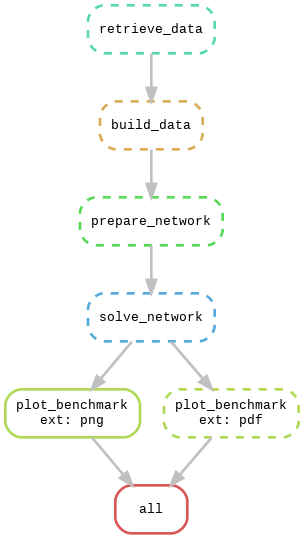

In [ ]:
Image("dag_minimal.png")

Rules that need to be executed will be presented as plain lines, while those that have already been executed will be presented as dotted lines. An alternative to the DAG is the `rulegraph`. This graph is typically less crowded as you will only visualize the dependency graph of rules. This representation is leaner than the DAG because rules are not repeated for wildcards.

In [ ]:
! snakemake -call all --rulegraph | python scripts/filter_dag.py | dot -Tpng -o rulegraph_minimal.png
# For Windows run instead:
# ! snakemake -call all --rulegraph | python scripts\\filter_dag.py | dot -Tpng -o rulegraph_minimal.png

Building DAG of jobs...


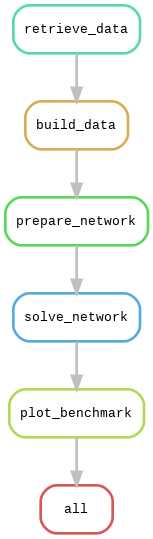

In [ ]:
Image("rulegraph_minimal.png")

As you can see, the `plot_benchmark` rule is only represented once.

Alternatively, you can also visualize a `filegraph`, which is similar to the `rulegraph` but includes some information about the inputs and outputs to each of the rules.

In [ ]:
! snakemake -call all --filegraph | python scripts/filter_dag.py | dot -Tsvg -o filegraph_minimal.svg
# For Windows run instead:
# ! snakemake -call all --filegraph | python scripts\\filter_dag.py | dot -Tsvg -o filegraph_minimal.svg

Building DAG of jobs...


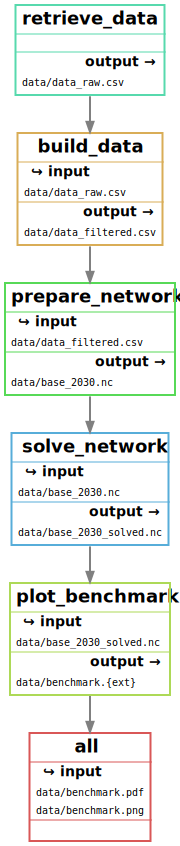

In [ ]:
SVG("filegraph_minimal.svg")

## Task 1: Executing a workflow with Snakemake

**a)** For our minimal example, execute a `dry-run` to produce the intermediate file `data/base_2030.nc`.

**b)** Execute the entire workflow and investigate what happens if you try to execute the workflow again.

**c)** Delete the final output file `data/benchmark.pdf` and investigate what happens if you try to execute the workflow again.

**d)** Change a value in the raw input data file `data/data_raw.csv` and save it again, overwriting the original file. Investigate what happens if you try to execute the workflow again.

Hint: You can also just `touch` the file by executing `Path("data/data_raw.csv").touch()`. This will mimic a file edit.

**e)** (Optional) Open the `Snakefile` and add a second rule that processes the file `data_raw_2.csv` using the same script as the `build_data` rule. Add the output of this new rule as a second input to the `prepare_network` rule.

In [ ]:
# Your solution a)

In [ ]:
# Your solution b)

In [ ]:
# Your solution c)

In [ ]:
# Your solution d)

In [ ]:
# Your solution e)

## ◼ PyPSA-Earth: Rules and Workflow

We can now use Snakemake to call some of the rules to produce outputs with the `PyPSA-Earth` model.

In order to make the Notebook and your google drive light, we will use a pre-prepared rulegraph and DAG because we would need to have the full repo and input data to produce them here.

#### ▪ Visualizing the `Rulegraph` of a workflow

First, we can plot the `rule graph` of PyPSA-Earth `electrcity only` model and then the `sector coupled` model.

`electrcity only`:

For `electrcity only` we run:

```bash
! snakemake -call --configfile config.yaml --rulegraph solve_all_networks | python scripts/filter_dag.py | dot -Tpng -o rulegraph_pypsa_earth_elec_only_model.png`
```

Then running the following command will show the Rulegraph to PyPSA-Earth electricity only workflow:
```bash
Image("rulegraph_pypsa_earth_elec_only_model.png")
```

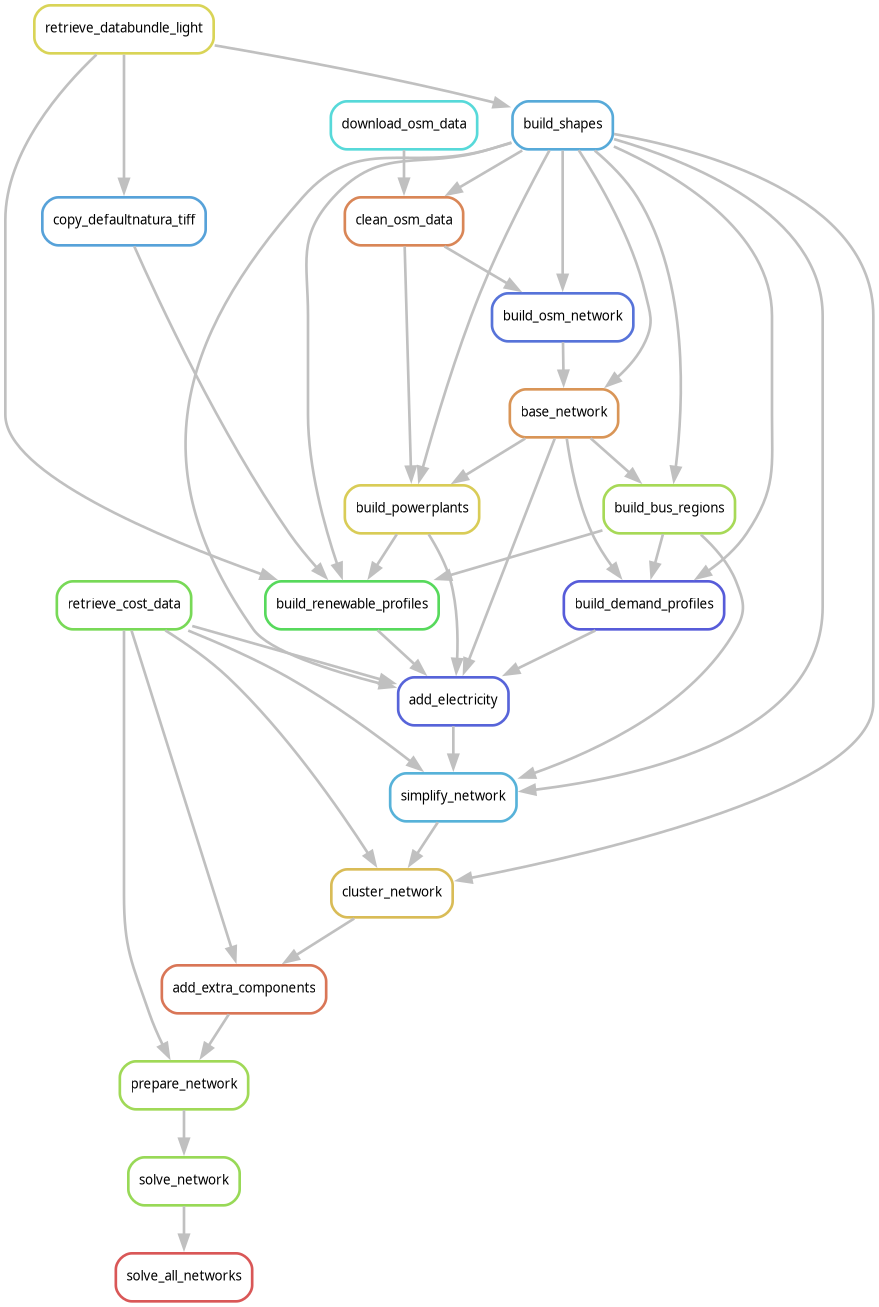

As for `Sector-coupled` we run:

```bash
! snakemake -call --configfile config.yaml --rulegraph solve_sector_networks | python scripts/filter_dag.py | dot -Tpng -o rulegraph_pypsa_earth_model.png`
```

Then running the following command will show the Rulegraph to PyPSA-Earth sector-coupled workflow:
```bash
Image("rulegraph_pypsa_earth_model.png")
```

Note that the difference in the commmand is only `--rulegraph solve_all_networks` for electricity only and `--rulegraph solve_sector_networks` for sector-coupled.

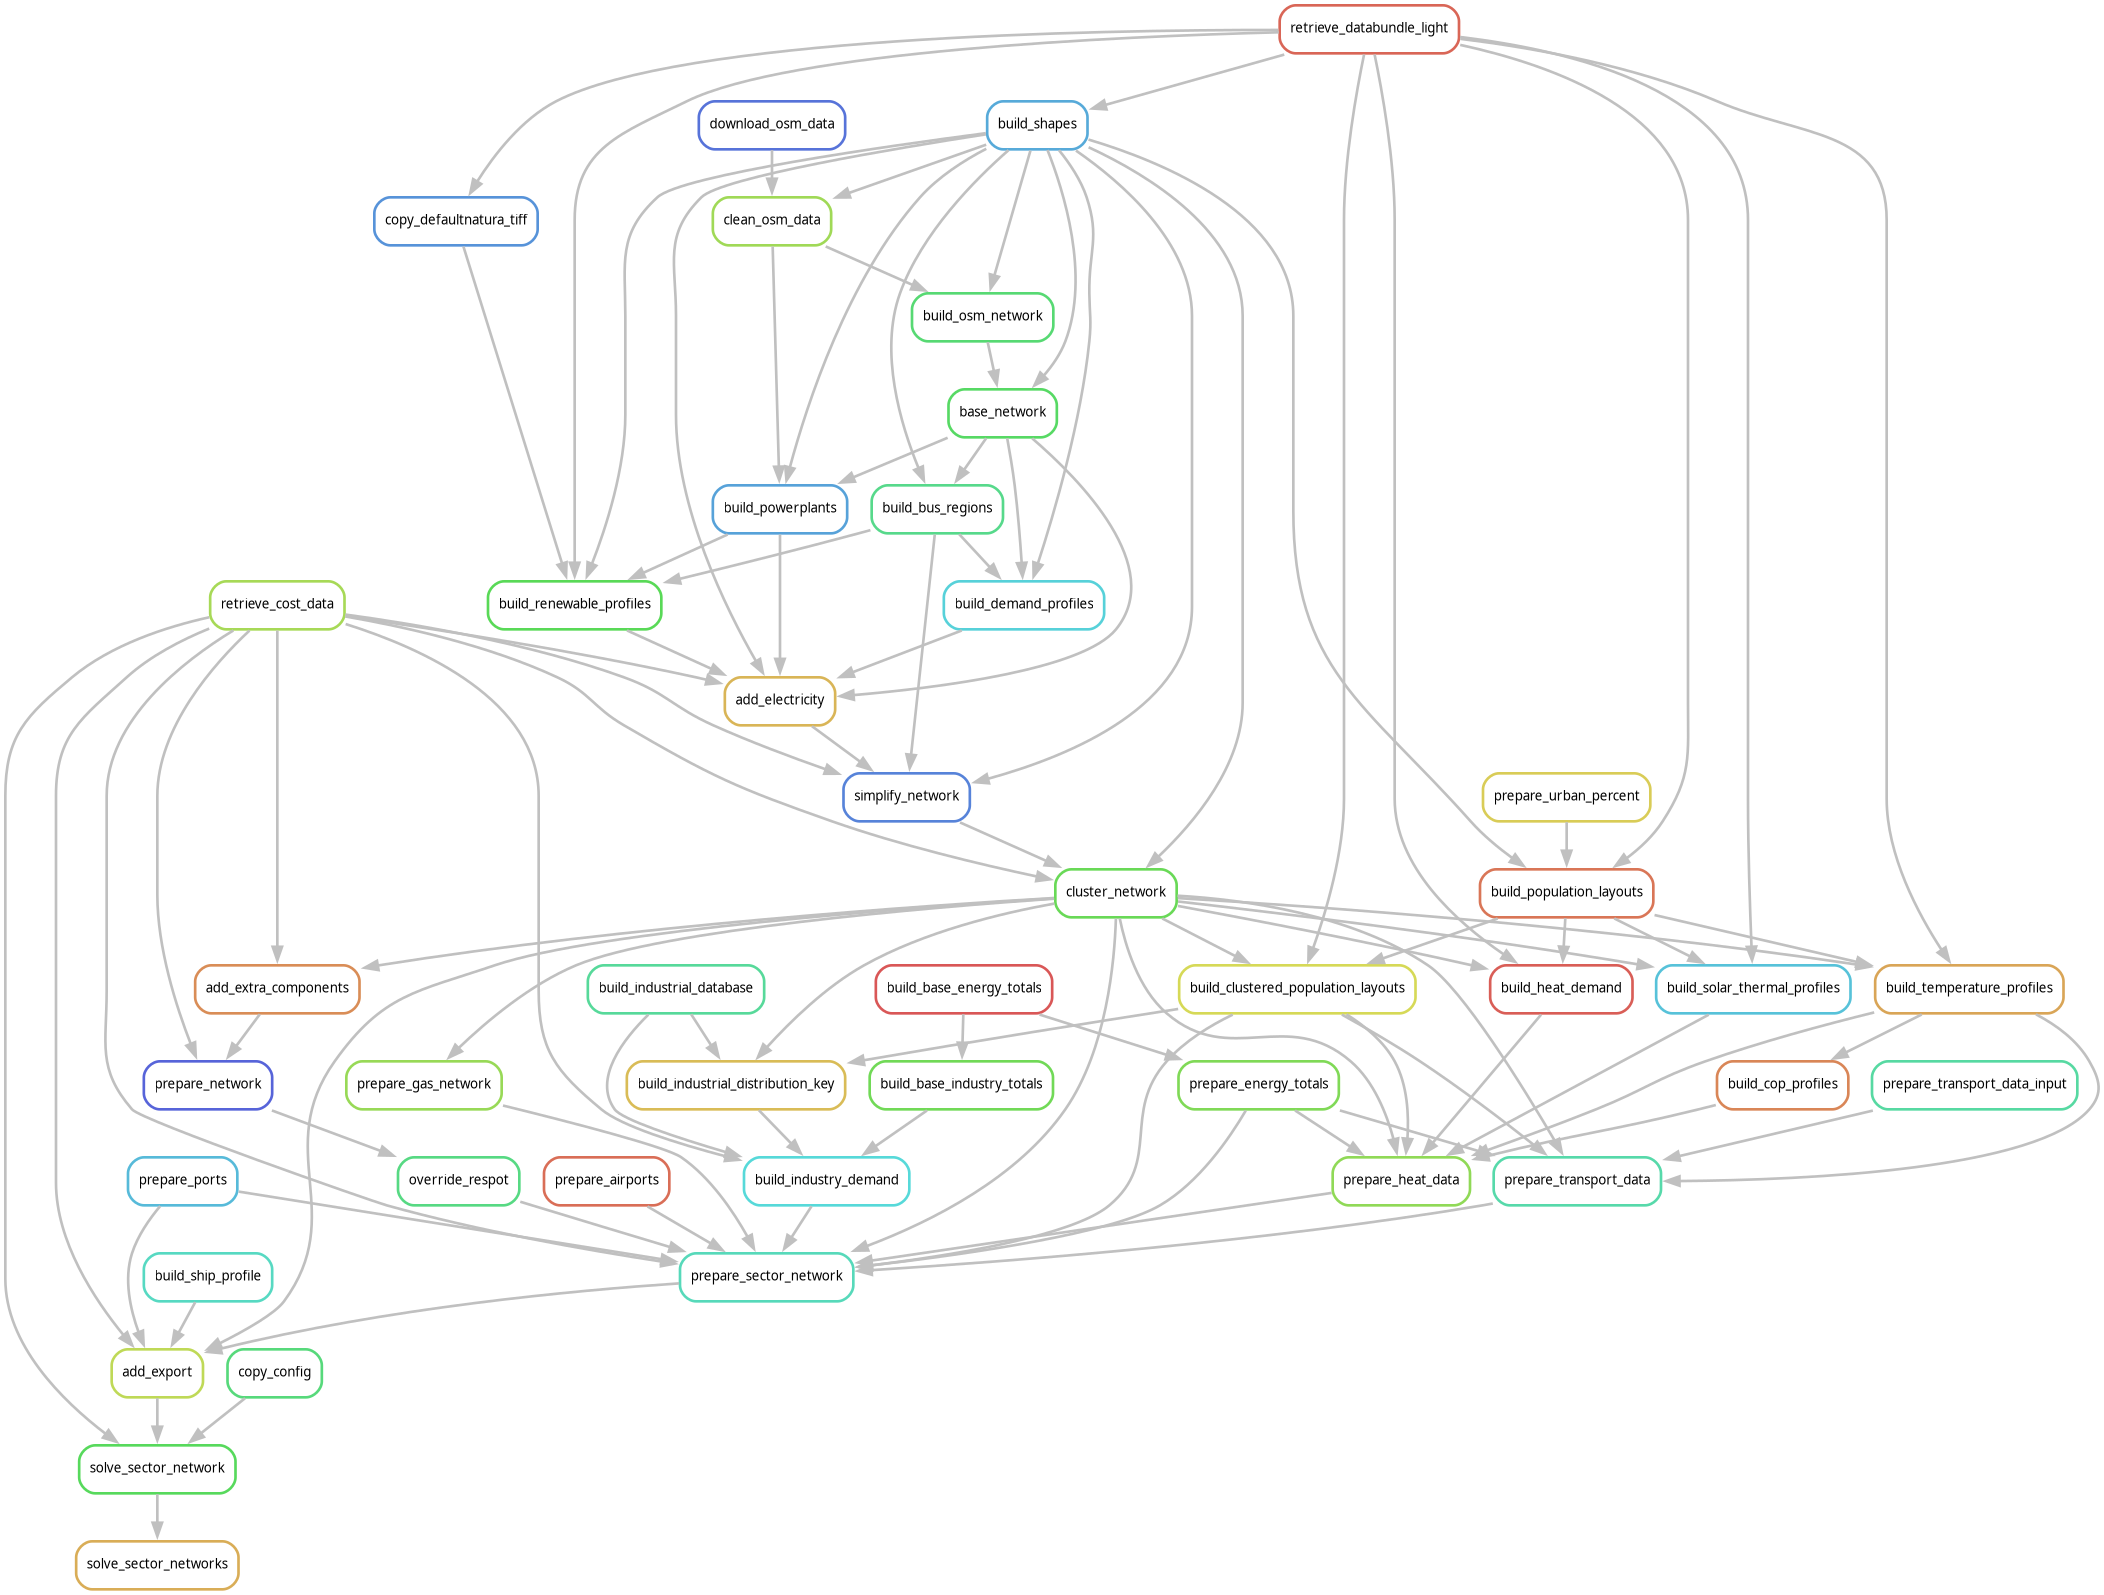

#### ▪ Visualizing the `Filegraph` of a workflow

For `Electricity only` we run:

```bash
! snakemake -call --configfile config.yaml --filegraph solve_all_networks     | python scripts/filter_dag.py     | dot -Tsvg -o filegraph_elec_only.svg`
```

As for the `Sector-coupled` the file graph is large. Try it at home 😉

filegraph_turkey.svg

## ◼ Inspect `prepare_energy_totals` rule

Now we need to restore the default working directory using `os.chdir("../")`.

In [ ]:
os.chdir("../")

Check if the default directory is set:

In [ ]:
os.getcwd()

'/content'

Download necessary files to inspect the rule:

In [ ]:
# @markdown We will download the necessary data to inspect the prepare_energy_totals rule.
# @markdown   * `Snakefile`: The Snakefile that orchestrates the worflow based on input/outputs of the rules.
# @markdown   * `prepare_energy_totals.py`: The Python script implementing the logic to compute energy totals.
# @markdown   * `config.yaml`: Configuration file specifying countries, settings, and workflow parameters.

# --- Google Drive direct download URLs ---
urls = {
    "Snakefile"                        : "https://drive.google.com/uc?id=1NQXWO7eXsPfzoIP_bj8wrpKcD2UVdAuV",
    "scripts/prepare_energy_totals.py" : "https://drive.google.com/uc?id=1Va22j6eYo6a5qtsRAoyYS8REpeEsdYUN",
    "config.yaml"                      : "https://drive.google.com/uc?id=13J8ebAcW43EkOUT7ggBxOKt-phISj2a0",
    "scripts/_helpers.py"              : "https://drive.google.com/uc?id=1w_02ufeEPNQVd10vQjQ8WUWM_UEL5mBn",
    "data/base_energy_total.csv"       : "https://drive.google.com/uc?id=1vw2qnCinyxdK1OLtFjaOhlu8KHqstemt",
    "data/growth_factors_cagr.csv"     : "https://drive.google.com/uc?id=18nNzWs8xzi9yBQ690SZrWZ7kpvZ2TQ2N",
    "data/fuel_shares.csv"             : "https://drive.google.com/uc?id=1EjQ56ATrRPhgX1nRakW6rIuuxFpVoJAv",
    "data/efficiency_gains_cagr.csv"   : "https://drive.google.com/uc?id=16u0hgJhWbjOXoZb5oiiMiaEsw0I7uD9b",
    "data/district_heating.csv"        : "https://drive.google.com/uc?id=1khLu8PhES2x4Riy2KG0qXu1JX508UMTr",
}

# --- Download each file ---
for filepath, url in urls.items():
    print(f"⬇️  Downloading {filepath} ...")

    # Extract folder path (e.g. 'scripts', 'data')
    folder = os.path.dirname(filepath)

    # Create directory if needed
    if folder and not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
        print(f"📁 Created folder: {folder}")

    # Download the file to its path
    try:
        gdown.download(url, filepath, quiet=False)
        print(f"✅ Saved as {filepath}\n")
    except Exception as e:
        print(f"❌ Failed to download {filepath}: {e}\n")

print("🎉 All downloads complete.")


⬇️  Downloading Snakefile ...


Downloading...
From: https://drive.google.com/uc?id=1NQXWO7eXsPfzoIP_bj8wrpKcD2UVdAuV
To: /content/Snakefile
100%|██████████| 83.0k/83.0k [00:00<00:00, 16.5MB/s]


✅ Saved as Snakefile

⬇️  Downloading scripts/prepare_energy_totals.py ...


Downloading...
From (original): https://drive.google.com/uc?id=1Va22j6eYo6a5qtsRAoyYS8REpeEsdYUN
From (redirected): https://drive.google.com/uc?id=1Va22j6eYo6a5qtsRAoyYS8REpeEsdYUN&confirm=t&uuid=4b792ee8-5a36-4208-9878-e48c9509d663
To: /content/scripts/prepare_energy_totals.py
100%|██████████| 12.6k/12.6k [00:00<00:00, 21.1MB/s]


✅ Saved as scripts/prepare_energy_totals.py

⬇️  Downloading config.yaml ...


Downloading...
From: https://drive.google.com/uc?id=13J8ebAcW43EkOUT7ggBxOKt-phISj2a0
To: /content/config.yaml
100%|██████████| 39.1k/39.1k [00:00<00:00, 31.5MB/s]


✅ Saved as config.yaml

⬇️  Downloading scripts/_helpers.py ...


Downloading...
From (original): https://drive.google.com/uc?id=1w_02ufeEPNQVd10vQjQ8WUWM_UEL5mBn
From (redirected): https://drive.google.com/uc?id=1w_02ufeEPNQVd10vQjQ8WUWM_UEL5mBn&confirm=t&uuid=876da225-49d0-47fe-9583-a06b5df0b901
To: /content/scripts/_helpers.py
100%|██████████| 49.8k/49.8k [00:00<00:00, 31.9MB/s]


✅ Saved as scripts/_helpers.py

⬇️  Downloading data/base_energy_total.csv ...


Downloading...
From: https://drive.google.com/uc?id=1vw2qnCinyxdK1OLtFjaOhlu8KHqstemt
To: /content/data/base_energy_total.csv
100%|██████████| 1.03k/1.03k [00:00<00:00, 2.57MB/s]


✅ Saved as data/base_energy_total.csv

⬇️  Downloading data/growth_factors_cagr.csv ...


Downloading...
From: https://drive.google.com/uc?id=18nNzWs8xzi9yBQ690SZrWZ7kpvZ2TQ2N
To: /content/data/growth_factors_cagr.csv
100%|██████████| 1.44k/1.44k [00:00<00:00, 4.13MB/s]


✅ Saved as data/growth_factors_cagr.csv

⬇️  Downloading data/fuel_shares.csv ...


Downloading...
From: https://drive.google.com/uc?id=1EjQ56ATrRPhgX1nRakW6rIuuxFpVoJAv
To: /content/data/fuel_shares.csv
100%|██████████| 475/475 [00:00<00:00, 1.25MB/s]


✅ Saved as data/fuel_shares.csv

⬇️  Downloading data/efficiency_gains_cagr.csv ...


Downloading...
From: https://drive.google.com/uc?id=16u0hgJhWbjOXoZb5oiiMiaEsw0I7uD9b
To: /content/data/efficiency_gains_cagr.csv
100%|██████████| 1.41k/1.41k [00:00<00:00, 3.72MB/s]


✅ Saved as data/efficiency_gains_cagr.csv

⬇️  Downloading data/district_heating.csv ...


Downloading...
From: https://drive.google.com/uc?id=1khLu8PhES2x4Riy2KG0qXu1JX508UMTr
To: /content/data/district_heating.csv
100%|██████████| 49.0/49.0 [00:00<00:00, 158kB/s]

✅ Saved as data/district_heating.csv

🎉 All downloads complete.


#### ▪ In the `snakemake` file:

In [ ]:
# @markdown The rule how it looks like in the Snakefile:
snakefile = Path("Snakefile")
text = snakefile.read_text()

# Show only the part of the Snakefile that mentions 'prepare_energy_totals'
start = text.find("rule prepare_energy_totals")
if start == -1:
    print("Could not find rule 'prepare_energy_totals' in Snakefile.")
else:
    snippet = text[start:start+755]  # 755 chars after start
    print(snippet)

rule prepare_energy_totals:
    params:
        countries=config["countries"],
        base_year=config["demand_data"]["base_year"],
        sector_options=config["sector"],
        energy_demand=config["custom_data"]["sectoral_energy_demand"],
    input:
        unsd_paths="resources/" + SECDIR + "energy_totals_base.csv",
        efficiency_gains_cagr="data/demand/efficiency_gains_cagr.csv",
        growth_factors_cagr="data/demand/growth_factors_cagr.csv",
        district_heating="data/demand/district_heating.csv",
        fuel_shares="data/demand/fuel_shares.csv",
    output:
        energy_totals="resources/"
        + SECDIR
        + "energy_totals_{demand}_{planning_horizons}.csv",
    script:
        "scripts/prepare_energy_totals.py"




#### ▪ Open the script prepare_energy_totals.py

In [ ]:
script_path = Path("scripts/prepare_energy_totals.py")
if script_path.exists():
    print(script_path.read_text())
else:
    print("prepare_energy_totals.py not found – check your paths.")

# -*- coding: utf-8 -*-
# SPDX-FileCopyrightText:  PyPSA-Earth and PyPSA-Eur Authors
#
# SPDX-License-Identifier: AGPL-3.0-or-later
import glob
import logging
import os
import sys
from io import BytesIO
from pathlib import Path
from urllib.request import urlopen
from zipfile import ZipFile

import country_converter as coco
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import py7zr
import requests
from _helpers import BASE_DIR, read_csv_nafix, three_2_two_digits_country

_logger = logging.getLogger(__name__)


def get(item, investment_year=None):
    """
    Check whether item depends on investment year.
    """
    if isinstance(item, dict):
        return item[investment_year]
    else:
        return item


def calculate_end_values(df, no_years):
    return (1 + df) ** no_years


if __name__ == "__main__":
    if "snakemake" not in globals():
        from _helpers import mock_snakemake

        snakemake = mock_snakemake(
            "prepare_energy_totals",


#### ▪ Import and run the script logic directly

##### ▪▪ Import the script as a module

This is a nice trick: treat `prepare_energy_totals.py` as a module and call its functions.

In [ ]:
import sys

# Add the "scripts" folder to module search path
sys.path.append(str(Path("scripts").resolve()))

# Path to your script
script_path = Path("scripts/prepare_energy_totals.py")

# Create import spec
spec = importlib.util.spec_from_file_location(
    "scripts.prepare_energy_totals",
    script_path
)

# Load module
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

##### ▪▪ Load input data:

In [ ]:
base_energy_totals = mod.read_csv_nafix("data/base_energy_total.csv", index_col=0)
growth_factors_cagr = mod.read_csv_nafix("data/growth_factors_cagr.csv", index_col=0)
efficiency_gains_cagr = mod.read_csv_nafix("data/efficiency_gains_cagr.csv", index_col=0)
fuel_shares = mod.read_csv_nafix("data/fuel_shares.csv", index_col=0)
district_heating = mod.read_csv_nafix("data/district_heating.csv", index_col=0)

with open('config.yaml', "r") as f:
    cfg = yaml.safe_load(f)

In [ ]:
base_energy_totals

,Unnamed: 0,agriculture biomass,agriculture electricity,agriculture oil,electricity rail,electricity residential,residential biomass,residential gas,residential heat biomass,residential heat gas,...,road electricity,road gas,road biomass,road oil,agriculture coal,non energy electricity,non energy oil,non energy biomass,non energy gas,non energy heat
TR,NaN,0.0,9.5714,35.7245,1.2877,81.0699,8.906,153.1574,NaN,NaN,...,0.0,1.032,1.8024,304.6684,0.0,0.0,37.755,0.0,6.1493,0.0


In [ ]:
growth_factors_cagr

,total residential space,total residential water,electricity residential,total services space,total services water,total road,total rail,electricity rail,total domestic aviation,total international aviation,...,services biomass,services gas,residential heat oil,residential heat biomass,residential heat gas,other electricity,other oil,other gas,other biomass,other heat
DEFAULT,0.02156,0.02500,0.05568,0.01786,0.02156,0.0139,0.0494,0.03982,0.03715,0.02156,...,0.0,-0.006114,0.000,0.0000,0.0000,0.00000,0.00,0.00000,0.000,0.0
MA,0.02156,0.02504,0.05568,0.01786,0.02156,0.0139,0.0494,0.03982,0.03715,0.02156,...,0.0,-0.006114,0.000,0.0000,0.0000,0.05568,0.00,0.01095,0.000,0.0
TN,0.02000,0.00000,0.01500,0.00000,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000,...,0.0,0.000000,0.000,0.0000,0.0000,0.01500,0.00,0.00000,0.000,0.0
NA,0.00000,0.00000,0.05300,0.00000,0.00000,0.0038,0.0000,0.00000,0.00000,0.00000,...,0.0,0.000000,0.000,0.0000,0.0000,0.05300,0.12,0.04500,0.154,0.0
US,0.00800,0.00390,0.00900,0.00900,0.01900,0.0076,0.0010,0.00000,0.02500,0.03300,...,0.0,0.000000,-0.022,-0.0071,-0.0049,0.00000,0.00,0.00000,0.000,0.0


In [ ]:
fuel_shares

,oil residential heat share,biomass residential heat share,biomass to elec heat share,oil to elec heat share,biomass to elec share,oil to elec share,space to water heat share,gas to elec share,gas to elec heat share,gas residential heat share
country,,,,,,,,,,
DEFAULT,0.6667,0.750,0.00,0.5,0.00,0.5,0.60,0.00,0.0,0.75
MA,0.6667,0.750,0.00,0.5,0.00,0.5,0.60,0.00,0.0,0.75
TN,0.0000,0.110,0.37,0.0,0.01,0.0,0.01,0.98,0.0,NaN
NA,0.0250,0.017,0.76,NaN,NaN,NaN,0.00,0.00,0.0,NaN
US,0.8800,1.000,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.72


In [ ]:
district_heating

,current,potential
country,,
DEFAULT,0,0
MA,0,0


In [ ]:
demand_sc = 'AP'
investment_year = 2050

base_year = cfg.get("demand_data", {}).get("base_year", {})
no_years = investment_year - int(base_year)
growth_factors = mod.calculate_end_values(growth_factors_cagr, no_years)
efficiency_gains = mod.calculate_end_values(efficiency_gains_cagr, no_years)

In [ ]:
growth_factors

,total residential space,total residential water,electricity residential,total services space,total services water,total road,total rail,electricity rail,total domestic aviation,total international aviation,...,services biomass,services gas,residential heat oil,residential heat biomass,residential heat gas,other electricity,other oil,other gas,other biomass,other heat
DEFAULT,1.937226,2.150007,5.364152,1.731129,1.937226,1.534083,4.458337,3.355082,3.098052,1.937226,...,1.0,0.826863,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
MA,1.937226,2.152609,5.364152,1.731129,1.937226,1.534083,4.458337,3.355082,3.098052,1.937226,...,1.0,0.826863,1.00000,1.000000,1.000000,5.364152,1.000000,1.401587,1.000000,1.0
TN,1.847589,1.000000,1.586526,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.000000,1.00000,1.000000,1.000000,1.586526,1.000000,1.000000,1.000000,1.0
NA,1.000000,1.000000,4.957692,1.000000,1.000000,1.124768,1.000000,1.000000,1.000000,1.000000,...,1.0,1.000000,1.00000,1.000000,1.000000,4.957692,33.555113,3.913857,84.796919,1.0
US,1.280196,1.128247,1.320159,1.320159,1.792255,1.264541,1.031470,1.000000,2.150007,2.735961,...,1.0,1.000000,0.50177,0.801809,0.858753,1.000000,1.000000,1.000000,1.000000,1.0


In [ ]:
countries = ["TR"]


for country in countries:
    if country not in efficiency_gains.index:
        efficiency_gains.loc[country] = efficiency_gains.loc["DEFAULT"]
        mod._logger.warning(
            "No efficiency gains cagr data for "
            + country
            + " using default data instead."
        )
    if country not in growth_factors.index:
        growth_factors.loc[country] = growth_factors.loc["DEFAULT"]
        mod._logger.warning(
            "No growth factors cagr data for "
            + country
            + " using default data instead."
        )
    if country not in fuel_shares.index:
        fuel_shares.loc[country] = fuel_shares.loc["DEFAULT"]
        mod._logger.warning(
            "No fuel share data for " + country + " using default data instead."
        )
    if country not in district_heating.index:
        district_heating.loc[country] = district_heating.loc["DEFAULT"]
        mod._logger.warning(
            "No heating data for " + country + " using default data instead."
        )

In [ ]:
efficiency_gains = efficiency_gains[efficiency_gains.index.isin(countries)]
fuel_shares = fuel_shares[fuel_shares.index.isin(countries)]
district_heating = district_heating[district_heating.index.isin(countries)]
growth_factors = growth_factors[growth_factors.index.isin(countries)]

In [ ]:
options = cfg.get("sector", {})

key = f"{demand_sc}_{investment_year}"

fuel_cell_share = options.get("land_transport_fuel_cell_share", {}).get(key)
electric_share = options.get("land_transport_electric_share", {}).get(key)
hydrogen_shipping_share = options.get("shipping_hydrogen_share", {}).get(key)

In [ ]:
energy_totals = (
    base_energy_totals
    * efficiency_gains.loc[countries]
    * growth_factors.loc[countries]
)

energy_totals

,Unnamed: 0,agriculture biomass,agriculture coal,agriculture electricity,agriculture oil,district heat share,electricity rail,electricity residential,electricity residential space,electricity residential water,...,total navigation oil,total rail,total residential space,total residential water,total road,total road ev,total road fcev,total road ice,total services space,total services water
TR,NaN,0.0,NaN,17.053366,16.209019,NaN,4.041987,399.958688,NaN,NaN,...,NaN,10.125128,21.604053,13.486876,NaN,NaN,NaN,NaN,0.0,0.0


In [ ]:
# Residential

efficiency_heat_oil_to_elec = options.get("efficiency_heat_oil_to_elec", {})
efficiency_heat_biomass_to_elec = options.get("efficiency_heat_biomass_to_elec", {})
efficiency_heat_gas_to_elec = options.get("efficiency_heat_gas_to_elec", {})

energy_totals["electricity residential space"] = (
    base_energy_totals["total residential space"]
    + (
        fuel_shares["biomass to elec heat share"]
        * fuel_shares["biomass residential heat share"]
        * (fuel_shares["space to water heat share"])
        * base_energy_totals["residential biomass"]
        * efficiency_heat_biomass_to_elec
    )
    + (
        fuel_shares["oil to elec heat share"]
        * fuel_shares["oil residential heat share"]
        * (fuel_shares["space to water heat share"])
        * base_energy_totals["residential oil"]
        * efficiency_heat_oil_to_elec
    )
    + (
        fuel_shares["gas to elec heat share"]
        * fuel_shares["gas residential heat share"]
        * (fuel_shares["space to water heat share"])
        * base_energy_totals["residential gas"]
        * efficiency_heat_gas_to_elec
    )
)

energy_totals["electricity residential water"] = (
    base_energy_totals["total residential water"]
    + (
        fuel_shares["biomass to elec heat share"]
        * fuel_shares["biomass residential heat share"]
        * (1 - fuel_shares["space to water heat share"])
        * base_energy_totals["residential biomass"]
        * efficiency_heat_biomass_to_elec
    )
    + (
        fuel_shares["oil to elec heat share"]
        * fuel_shares["oil residential heat share"]
        * (1 - fuel_shares["space to water heat share"])
        * base_energy_totals["residential oil"]
        * efficiency_heat_oil_to_elec
    )
    + (
        fuel_shares["gas to elec heat share"]
        * fuel_shares["gas residential heat share"]
        * (1 - fuel_shares["space to water heat share"])
        * base_energy_totals["residential gas"]
        * efficiency_heat_gas_to_elec
    )
)

energy_totals["residential heat oil"] = (
    base_energy_totals["residential oil"]
    * fuel_shares["oil residential heat share"]
    * (1 - fuel_shares["oil to elec heat share"])
    * efficiency_gains["residential heat oil"]
    * growth_factors["residential heat oil"]
)

energy_totals["residential oil"] = (
    base_energy_totals["residential oil"]
    * (1 - fuel_shares["oil residential heat share"])
    * (1 - fuel_shares["oil to elec share"])
    * efficiency_gains["residential oil"]
    * growth_factors["residential oil"]
)

energy_totals["residential heat biomass"] = (
    base_energy_totals["residential biomass"]
    * fuel_shares["biomass residential heat share"]
    * (1 - fuel_shares["biomass to elec heat share"])
    * efficiency_gains["residential heat biomass"]
    * growth_factors["residential heat biomass"]
)

energy_totals["residential biomass"] = (
    base_energy_totals["residential biomass"]
    * (1 - fuel_shares["biomass residential heat share"])
    * (1 - fuel_shares["biomass to elec share"])
    * efficiency_gains["residential biomass"]
    * growth_factors["residential biomass"]
)

energy_totals["residential heat gas"] = (
    base_energy_totals["residential gas"]
    * fuel_shares["gas residential heat share"]
    * (1 - fuel_shares["gas to elec heat share"])
    * efficiency_gains["residential heat gas"]
    * growth_factors["residential heat gas"]
)

energy_totals["residential gas"] = (
    base_energy_totals["residential gas"]
    * (1 - fuel_shares["gas residential heat share"])
    * (1 - fuel_shares["gas to elec share"])
    * efficiency_gains["residential gas"]
    * growth_factors["residential gas"]
)

energy_totals["total residential space"] = energy_totals[
    "electricity residential space"
] + (
    energy_totals["residential heat oil"]
    + energy_totals["residential heat biomass"]
    + energy_totals["residential heat gas"]
) * (
    fuel_shares["space to water heat share"]
)

energy_totals["total residential water"] = energy_totals[
    "electricity residential water"
] + (
    energy_totals["residential heat oil"]
    + energy_totals["residential heat biomass"]
    + energy_totals["residential heat gas"]
) * (
    1 - fuel_shares["space to water heat share"]
)

energy_totals["electricity residential"] = (
    energy_totals["electricity residential"]
    + (
        fuel_shares["oil to elec share"]
        * (1 - fuel_shares["oil residential heat share"])
        * base_energy_totals["residential oil"]
    )
    + (
        fuel_shares["biomass to elec share"]
        * (1 - fuel_shares["biomass residential heat share"])
        * base_energy_totals["residential biomass"]
    )
    + (
        fuel_shares["gas to elec share"]
        * (1 - fuel_shares["gas residential heat share"])
        * base_energy_totals["residential gas"]
    )
)

In [ ]:
# Road
energy_totals["total road"] = (
    (1 - fuel_cell_share - electric_share)
    * efficiency_gains["total road ice"]
    * base_energy_totals["total road"]
    + fuel_cell_share
    * efficiency_gains["total road fcev"]
    * base_energy_totals["total road"]
    + electric_share
    * efficiency_gains["total road ev"]
    * base_energy_totals["total road"]
) * growth_factors["total road"]

# Navigation
energy_totals["total domestic navigation"] = (
    (1 - hydrogen_shipping_share)
    * efficiency_gains["total navigation oil"]
    * base_energy_totals["total domestic navigation"]
    + hydrogen_shipping_share
    * efficiency_gains["total navigation hydrogen"]
    * base_energy_totals["total domestic navigation"]
) * growth_factors["total domestic navigation"]

energy_totals["total international navigation"] = (
    (1 - hydrogen_shipping_share)
    * efficiency_gains["total navigation oil"]
    * base_energy_totals["total international navigation"]
    + hydrogen_shipping_share
    * efficiency_gains["total navigation hydrogen"]
    * base_energy_totals["total international navigation"]
) * growth_factors["total international navigation"]

energy_totals["district heat share"] = district_heating["current"]

energy_totals["electricity services space"] = 0
energy_totals["electricity services water"] = 0

In [ ]:
energy_totals.fillna(0)

,Unnamed: 0,agriculture biomass,agriculture coal,agriculture electricity,agriculture oil,district heat share,electricity rail,electricity residential,electricity residential space,electricity residential water,...,total navigation oil,total rail,total residential space,total residential water,total road,total road ev,total road fcev,total road ice,total services space,total services water
TR,0.0,0.0,0.0,17.053366,16.209019,0,4.041987,400.356932,13.437148,8.958098,...,0.0,10.125128,86.483521,57.65568,285.39157,0.0,0.0,0.0,0.0,0.0


In [ ]:
energy_totals

,Unnamed: 0,agriculture biomass,agriculture coal,agriculture electricity,agriculture oil,district heat share,electricity rail,electricity residential,electricity residential space,electricity residential water,...,total navigation oil,total rail,total residential space,total residential water,total road,total road ev,total road fcev,total road ice,total services space,total services water
TR,NaN,0.0,NaN,17.053366,16.209019,0,4.041987,400.356932,13.437148,8.958098,...,NaN,10.125128,86.483521,57.65568,285.39157,NaN,NaN,NaN,0.0,0.0


Prepare for plotting

In [ ]:
import pandas as pd
import numpy as np

# 1. Align shapes automatically
common_index = base_energy_totals.index.intersection(energy_totals.index)
common_cols  = base_energy_totals.columns.intersection(energy_totals.columns)

base_aligned = base_energy_totals.loc[common_index, common_cols]
proj_aligned = energy_totals.loc[common_index, common_cols]

# 2. Stack into tidy long form
df_base = (
    base_aligned
    .stack()
    .rename("value")
    .reset_index()
    .rename(columns={"level_0": "country", "level_1": "year"})
)
df_base["type"] = "base"

df_proj = (
    proj_aligned
    .stack()
    .rename("value")
    .reset_index()
    .rename(columns={"level_0": "country", "level_1": "year"})
)
df_proj["type"] = "projected"

# 3. Combine
df_long = pd.concat([df_base, df_proj], ignore_index=True)

df_long.head()


,country,year,value,type
0,TR,agriculture biomass,0.0000,base
1,TR,agriculture electricity,9.5714,base
2,TR,agriculture oil,35.7245,base
3,TR,electricity rail,1.2877,base
4,TR,electricity residential,81.0699,base


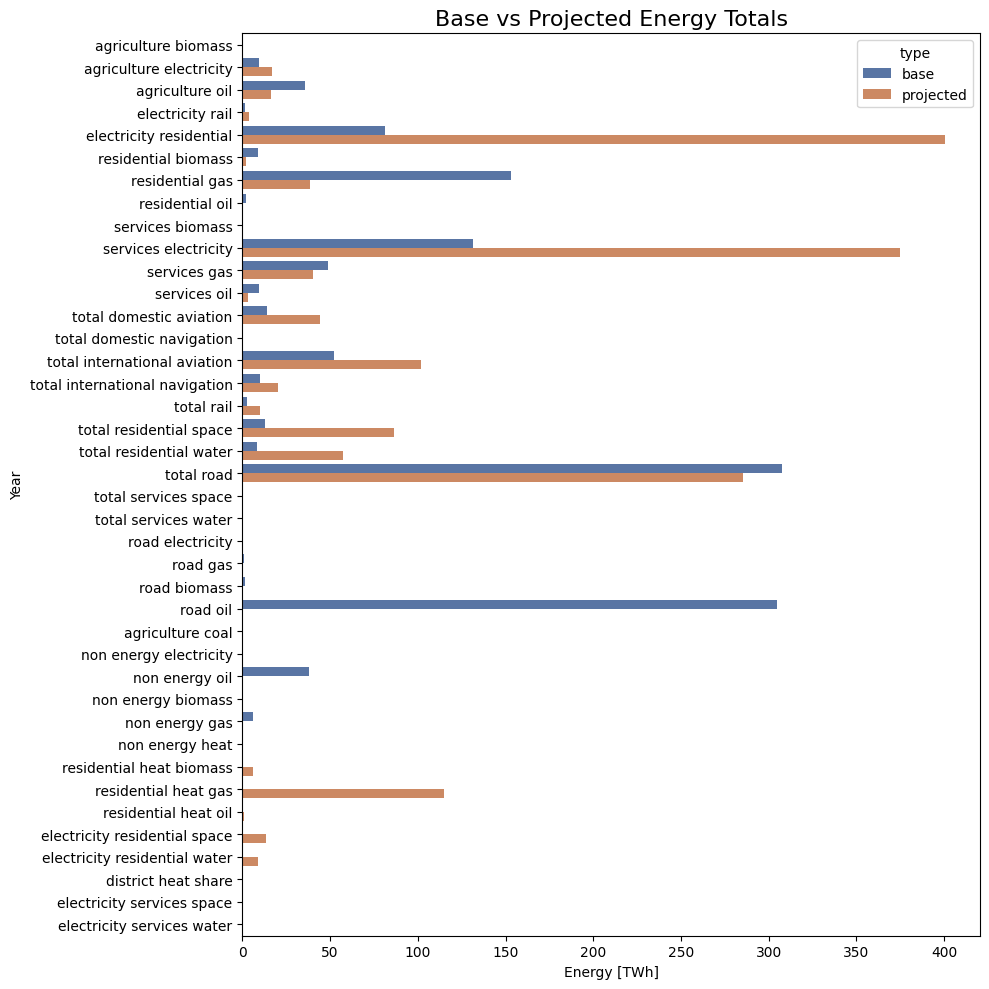

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

sns.barplot(
    data=df_long,
    y="year",          # horizontal axis becomes value
    x="value",
    hue="type",
    palette=["#4C72B0", "#DD8452"],  # no yellow
    orient="h"
)

plt.title("Base vs Projected Energy Totals", fontsize=16)
plt.xlabel("Energy [TWh]")
plt.ylabel("Year")
plt.tight_layout()
plt.show()


# Solutions

## Task 1: Executing a workflow with Snakemake

In [ ]:
# Solution a)
# ! snakemake -call data/base_2030.nc -n

In [ ]:
# Solution b)
# ! snakemake -call

In [ ]:
# Solution c)
# ! snakemake -call

In [ ]:
# Solution d)
# Path("data/data_raw.csv").touch()
# ! snakemake -call

In [ ]:
# Solution e)
# rule retrieve_data_2:
#     input:
#         "data/data_raw.csv"
#     output:
#         "data/data_raw_2.csv"
#     shell:
#         "cp {input} {output}"
#
# rule build_data_2:
#     input:
#         "data/data_raw_2.csv"
#     output:
#         "data/data_filtered_2.csv"
#     script:
#         "scripts/build_data.py"
#
# rule prepare_network:
#     input:
#         "data/data_filtered.csv",
#         "data/data_filtered_2.csv"
#     output:
#         "data/base_2030.nc"
#     script:
#         "scripts/prepare_network.py"